#### Samarth Singh - DS 5559 Exploratory Text Analytics - 6 May 2019

##Working Similar to the Coal Notebook

# Configuration

In [1]:
base_path = 'C:/Users/samar/OneDrive/Desktop/UVA/Stochastic Hydrology'
src_dir_coal = base_path + '/Data_Final/Coal_Final'
src_dir_gas = base_path + '/Data_Final/Gas_Final'
para_pat = r'\n\n+'
token_pat = r'([\W_]+)'
db_file = 'bios.db'

In [2]:
extra_stopwords = """
us rest went least would much must long one like much say well without though yet might still upon
done every rather particular made many previous always never thy thou go first oh thee ere ye came
almost could may sometimes seem called among another also however nevertheless even way one two three
ever put since became used need altogether likewise usual understand finally generally
""".strip().split()

In [3]:
OHCO = ['doc_id', 'para_id', 'sent_id', 'token_id']
DOCS = OHCO[:1]
#SUBJS = OHCO[:2]
#BTYPE = OHCO[:3] # a for autobiography, b otherwise
PARAS = OHCO[:2]
SENTS = OHCO[:3]

# Libraries

In [4]:
import glob
import re

import pandas as pd
from numpy.random import randint
import sys; sys.path.append(base_path)
import textman as tx
import sqlite3
import numpy as np

from sklearn.preprocessing import normalize
from sklearn.neighbors import KernelDensity as KDE
from sklearn.preprocessing import scale
import scipy.fftpack as fftpack

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import display, HTML

import nltk
from nltk.tokenize import RegexpTokenizer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('tagsets')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\samar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\samar\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\samar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package tagsets to
[nltk_data]     C:\Users\samar\AppData\Roaming\nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\samar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Pragmas

In [5]:
%matplotlib inline
sns.set()
plt.style.use('fivethirtyeight')

# Process

Imported all the text-files and created the corpus.

In [6]:
files = glob.glob(src_dir_gas+'/*.txt')
corpus = pd.DataFrame([f.replace('.txt','').split('/')[-1].split('-') for f in files], 
                    columns=['a','doc_id'])
#corpus['bio_type'] = corpus['bio_type'].map(lambda x: x.lstrip('Bios\\'))
#corpus = corpus[BTYPE]
corpus['doc_content'] = [open(f, 'r', encoding='ISO-8859-1').read() for f in files]
#stuff = corpus[['subject_type','subject']]
#stuff.to_csv('stuff.csv', index = True, header = True)
#corpus.head()
#files
corpus=corpus.drop(['a'], axis=1)
corpus

,doc_id,doc_content
0,1,"ï»¿Hydraulic fracturing, often called fracking..."
1,10,ï»¿This paper uses the Analytic Hierarchy Proc...
2,11,"ï»¿Stalling progress in European, Chinese and ..."
3,2,ï»¿Growing attention has been paid to understa...
4,3,ï»¿Following the shale gas boom in the United ...
5,4,ï»¿Innovation in energy technology is framed a...
6,5,ï»¿Shale gas in the EU and its Member States f...
7,6,ï»¿In consideration of the size and geographic...
8,7,ï»¿The notion of a âpolicy mixâ can descri...
9,8,ï»¿The paper examines shale gas development as...


### Set OHCO Index

In [7]:
try:
    corpus = corpus.set_index(DOCS)
    corpus = corpus.sort_index()
except KeyError:
    pass

### Create Stopword List

In [8]:
sw = nltk.corpus.stopwords.words('english') + extra_stopwords

### Fix some characters to improve tokenization

In [9]:
corpus.doc_content = corpus.doc_content.str.replace(r"(—|-)", ' \g<1> ')

## Documents to Paragraphs

In [10]:
paras = corpus.doc_content.str.split(para_pat, expand=True)\
    .stack()\
    .to_frame()\
    .rename(columns={0:'para_str'})
paras.index.names = PARAS
#paras.index.names = ['doc','para_num']
paras.para_str = paras.para_str.str.strip()
paras.para_str = paras.para_str.str.replace(r'\n', ' ')
paras.para_str = paras.para_str.str.replace(r'\s+', ' ')
paras = paras[~paras.para_str.str.match(r'^\s*$')]

## Paragraphs to Sentences

In [11]:
sents = paras.para_str\
    .apply(lambda x: pd.Series(nltk.sent_tokenize(x)))\
    .stack()\
    .to_frame()\
    .rename(columns={0:'sent_str'})
sents.index.names = SENTS

## Sentences to Tokens with POS tagging

In [12]:
tokenizer = RegexpTokenizer(r'\w+')

In [13]:
tokens = sents.sent_str\
    .apply(lambda x: pd.Series(nltk.pos_tag(tokenizer.tokenize(x))))\
    .stack()\
    .to_frame()\
    .rename(columns={0:'pos_tuple'})
tokens.index.names = OHCO
tokens['pos'] = tokens.pos_tuple.apply(lambda x: x[1])
tokens['token_str'] = tokens.pos_tuple.apply(lambda x: x[0])
tokens = tokens.drop('pos_tuple', 1)

### Tag punctuation and numbers

In [14]:
tokens['punc'] = tokens.token_str.str.match(r'^[\W_]*$').astype('int')
tokens['num'] = tokens.token_str.str.match(r'^.*\d.*$').astype('int')

In [15]:
tokens.sample(15)

pos        token_str  punc  num
doc_id para_id sent_id token_id                                 
4      19      3       4         NNS           scores     0    0
       28      3       8          WP              who     0    0
5      32      1       13        NNS          changes     0    0
4      9       11      1          RB     historically     0    0
       28      4       8          NN      governmentâ     0    0
11     18      6       13         CC              and     0    0
4      14      6       25         RB  institutionally     0    0
3      4       2       19         IN             from     0    0
       32      9       40         NN            shale     0    0
2      21      0       1          CD                1     0    1
7      31      2       11         MD           should     0    0
5      8       1       17         RB         actually     0    0
9      31      0       5          NN       subsurface     0    0
8      27      2       23         MD            would     0    0
4      2       0       29         NN                s     0    0

## Extract vocab with minimal normalization

In [16]:
WORDS = (tokens.punc == 0) & (tokens.num == 0)
tokens.loc[WORDS, 'term_str'] = tokens.token_str.str.lower().str.replace(token_pat, '')   
#.str.replace(r'["_*.\']', '')
vocab = tokens[tokens.punc == 0].term_str.value_counts().to_frame()\
    .reset_index()\
    .rename(columns={'index':'term_str', 'term_str':'n'})
vocab = vocab.sort_values('term_str').reset_index(drop=True)
vocab.index.name = 'term_id'

### Get priors for Vocab

In [17]:
vocab['p'] = vocab.n / vocab.n.sum()

### Add stems

In [18]:
stemmer = nltk.stem.porter.PorterStemmer()
vocab['port_stem'] = vocab.term_str.apply(lambda x: stemmer.stem(x))

### Define stopwords

In [19]:
stopwords = set(nltk.corpus.stopwords.words('english') + extra_stopwords)

In [20]:
sw = pd.DataFrame({'x':1}, index=stopwords)
vocab['stop'] = vocab.term_str.map(sw.x).fillna(0).astype('int')

### Add term_ids to Tokens

In [21]:
tokens['term_id'] = tokens['term_str'].map(vocab.reset_index()\
    .set_index('term_str').term_id).fillna(-1).astype('int')

In [22]:
vocab.sample(20)

,term_str,n,p,port_stem,stop
term_id,,,,,
4101,may,188,0.002144,may,1
3469,inspection,1,0.000011,inspect,0
1529,criterionâ,1,0.000011,criterionâ,0
4480,notorious,1,0.000011,notori,0
2250,entrenched,3,0.000034,entrench,0
5653,reorganization,1,0.000011,reorgan,0
7142,uranium,2,0.000023,uranium,0
2554,famously,1,0.000011,famous,0
260,alteration,1,0.000011,alter,0


### Delete extra tables

In [23]:
del(paras)
del(sents)
del(sw)
tokens

pos      token_str  punc  num  \
doc_id para_id sent_id token_id                                   
1      0       0       0           JJ              ï     0    0   
                       1          NNP      Hydraulic     0    0   
                       2           NN     fracturing     0    0   
                       3           RB          often     0    0   
                       4          VBD         called     0    0   
                       5           NN       fracking     0    0   
                       6          VBZ             is     0    0   
                       7           DT              a     0    0   
                       8           NN       drilling     0    0   
                       9           NN      technique     0    0   
                       10         WDT           that     0    0   
                       11         VBZ       accesses     0    0   
                       12          RB     previously     0    0   
                       13          JJ   inaccessible     0    0   
                       14          NN            oil     0    0   
                       15          NN            gas     0    0   
                       16         NNS       reserves     0    0   
               1       0           IN       Although     0    0   
                       1           DT            the     0    0   
                       2           NN        process     0    0   
                       3           MD          could     0    0   
                       4           VB            aid     0    0   
                       5          NNP              U     0    0   
                       6          NNP              S     0    0   
                       7           NN         energy     0    0   
                       8           NN   independence     0    0   
                       9          PRP             it     0    0   
                       10         VBZ             is     0    0   
                       11          JJ  controversial     0    0   
                       12          CC            and     0    0   
...                               ...            ...   ...  ...   
9      71      2       6           NN     literature     0    0   
                       7          VBZ        appears     0    0   
                       8           TO             to     0    0   
                       9           VB             be     0    0   
                       10          DT              a     0    0   
                       11          NN      sentiment     0    0   
                       12         WDT          which     0    0   
                       13          DT            the     0    0   
                       14          JJ        current     0    0   
                       15          JJ             UK     0    0   
                       16          NN     government     0    0   
                       17         NNS    understands     0    0   
                       18          CC            and     0    0   
                       19          CD            one     0    0   
                       20         WDT          which     0    0   
                       21         PRP             we     0    0   
                       22         VBP           urge     0    0   
                       23         PRP           them     0    0   
                       24          TO             to     0    0   
                       25          VB         retain     0    0   
                       26          IN             at     0    0   
                       27          DT            the     0    0   
                       28          NN         centre     0    0   
                       29          IN             of     0    0   
                       30        PRP$          their     0    0   
                       31          NN       approach     0    0   
                       32          TO             to     0    0   
              

In [24]:
# Developed in other notebook
lex_db = './lexicons.db'

OHCO = [ 'para_id', 'sent_id', 'token_id']
#CHAPS = OHCO[:1]
PARAS = OHCO[:1]
SENTS = OHCO[:2]

# emo = 'bing_sentiment'
emo = 'syu_sentiment'

# For KDE
kde_kernel = 'gaussian'
# kde_bandwidth = 100
kde_samples = 1000

In [25]:
with sqlite3.connect(lex_db) as db:
    combo = pd.read_sql('SELECT * FROM combo', db, index_col='term_str')
combo.head()

,nrc_anger,nrc_anticipation,nrc_disgust,nrc_fear,nrc_joy,nrc_negative,nrc_positive,nrc_sadness,nrc_surprise,nrc_trust,bing_negative,bing_positive,bing_sentiment,syu_sentiment,gi_sentiment
term_str,,,,,,,,,,,,,,,
abandon,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,-0.75,-1.0
abandoned,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,-0.50,NaN
abandoner,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.25,NaN
abandonment,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,-0.25,-1.0
abandons,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.00,NaN


In [26]:
emo_cols = combo.columns

In [27]:
FIG = dict(figsize=(25, 5), legend=True, fontsize=14, rot=45)
FIG

{'figsize': (25, 5), 'legend': True, 'fontsize': 14, 'rot': 45}

# Analysis

### Merge sentiment lexicon with vocab

In [28]:
tokens = tokens.join(combo, on='term_str', how='left')

In [29]:
tokens.head()

pos   token_str  punc  num    term_str  \
doc_id para_id sent_id token_id                                           
1      0       0       0          JJ           ï     0    0           ï   
                       1         NNP   Hydraulic     0    0   hydraulic   
                       2          NN  fracturing     0    0  fracturing   
                       3          RB       often     0    0       often   
                       4         VBD      called     0    0      called   

                                 term_id  nrc_anger  nrc_anticipation  \
doc_id para_id sent_id token_id                                         
1      0       0       0            7473        NaN               NaN   
                       1            3178        NaN               NaN   
                       2            2764        NaN               NaN   
                       3            4568        NaN               NaN   
                       4             822        NaN               NaN   

                                 nrc_disgust  nrc_fear  ...  nrc_negative  \
doc_id para_id sent_id token_id                         ...                 
1      0       0       0                 NaN       NaN  ...           NaN   
                       1                 NaN       NaN  ...           NaN   
                       2                 NaN       NaN  ...           NaN   
                       3                 NaN       NaN  ...           NaN   
                       4                 NaN       NaN  ...           NaN   

                                 nrc_positive  nrc_sadness  nrc_surprise  \
doc_id para_id sent_id token_id                                            
1      0       0       0                  NaN          NaN           NaN   
                       1                  NaN          NaN           NaN   
                       2                  NaN          NaN           NaN   
                       3                  NaN          NaN           NaN   
                       4                  NaN          NaN           NaN   

                                 nrc_trust  bing_negative  bing_positive  \
doc_id para_id sent_id token_id                                            
1      0       0       0               NaN            NaN            NaN   
                       1               NaN            NaN            NaN   
                       2               NaN            NaN            NaN   
                       3               NaN            NaN            NaN   
                       4               NaN            NaN            NaN   

                                 bing_sentiment  syu_sentiment  gi_sentiment  
doc_id para_id sent_id token_id                                               
1      0       0       0                    NaN            NaN           NaN  
                       1                    NaN            NaN           NaN  
                       2                    NaN            NaN           NaN  
                       3                    NaN            NaN           NaN  
                       4                    NaN            NaN           NaN  

[5 rows x 21 columns]

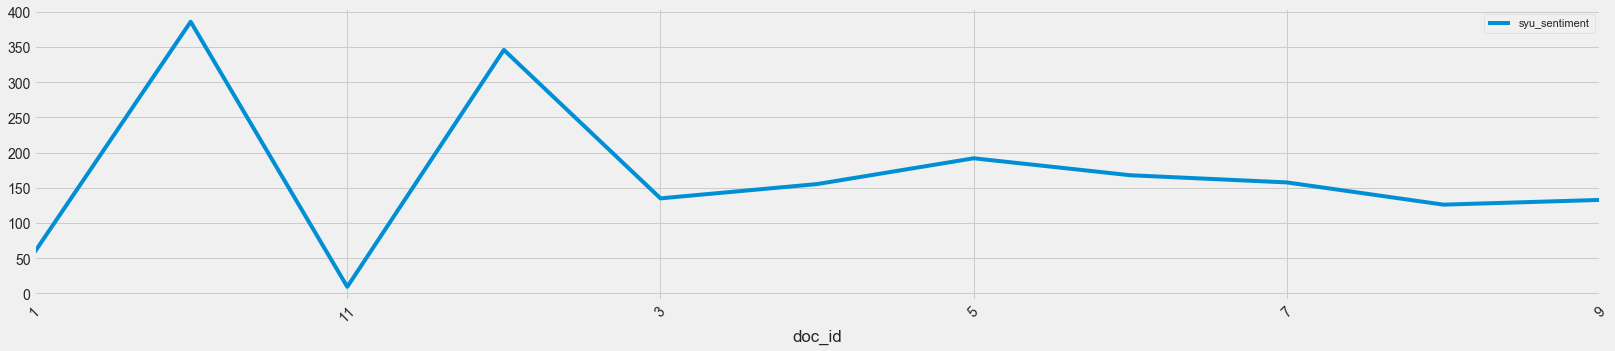

In [65]:
tokens.groupby(DOCS)[emo].sum().plot(**FIG)
tokens[emo_cols] = tokens[emo_cols].fillna(0)
#syu_sentiment seems to be pretty positive for coal

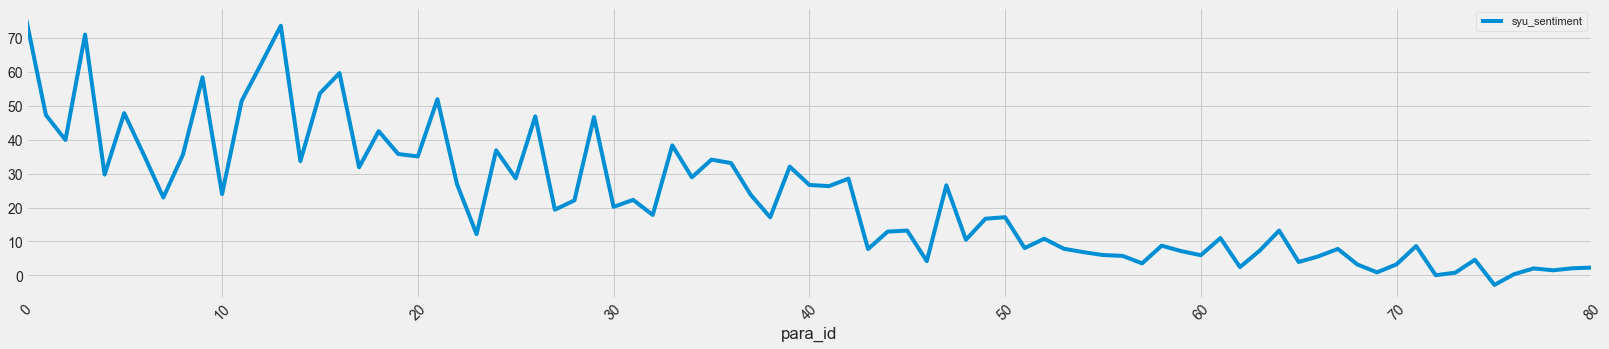

In [66]:
tokens.groupby(PARAS)[emo].sum().plot(**FIG)
tokens[emo_cols] = tokens[emo_cols].fillna(0)
#conclusion paras seem to be more dull

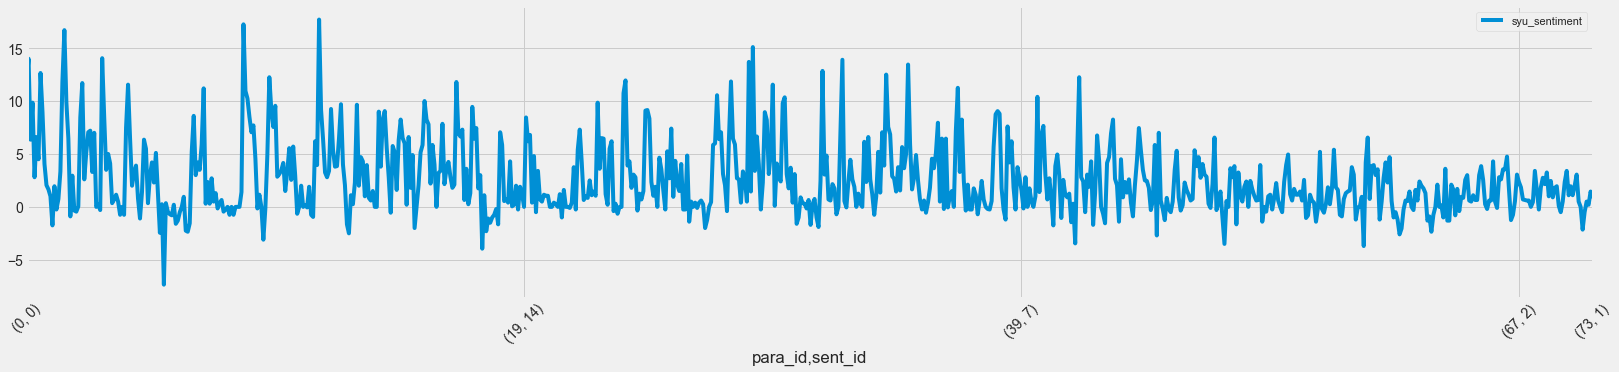

In [30]:
by_sent = tokens.groupby(SENTS)[emo_cols].sum()
max_x = by_sent.shape[0]
xticks = list(range(0, max_x, 250))
xticks.append(max_x - 1)
by_sent[emo].plot(**FIG, xticks=xticks)

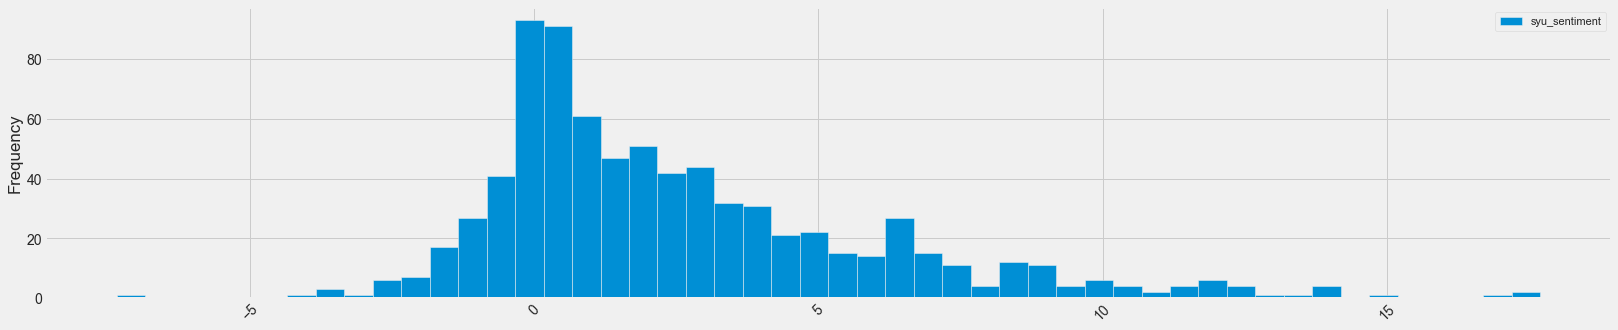

In [33]:
by_sent[emo].plot.hist(**FIG, bins=50)
#pretty positive

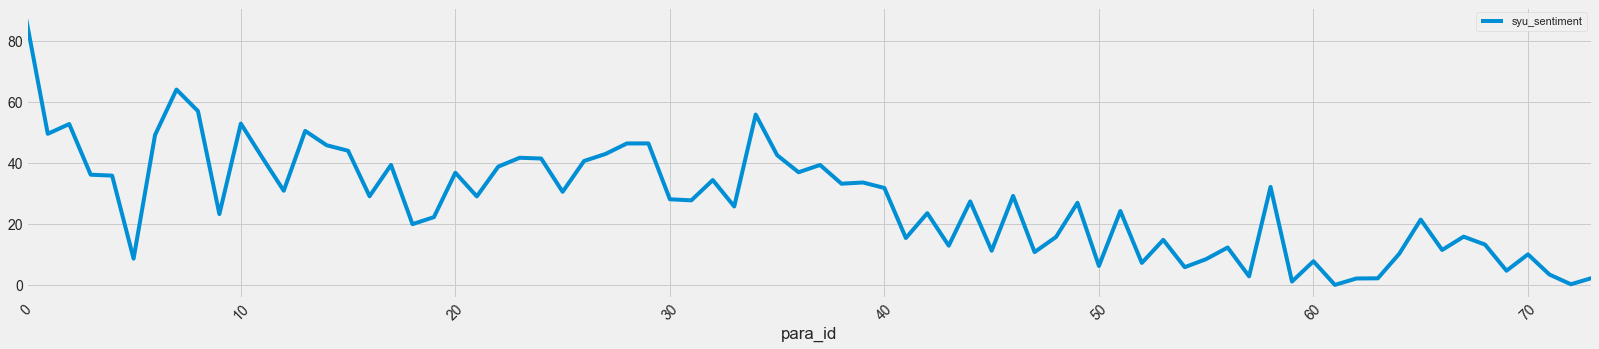

In [34]:
tokens.groupby(PARAS)[emo].sum().plot(**FIG)
tokens[emo_cols] = tokens[emo_cols].fillna(0)

In [36]:
xticks = [0]
xticks += by_sent[emo].reset_index().sort_values(emo).head(7).index.values.tolist()
xticks += by_sent[emo].reset_index().sort_values(emo).tail(7).index.values.tolist()
xticks += [by_sent.shape[0] - 1]

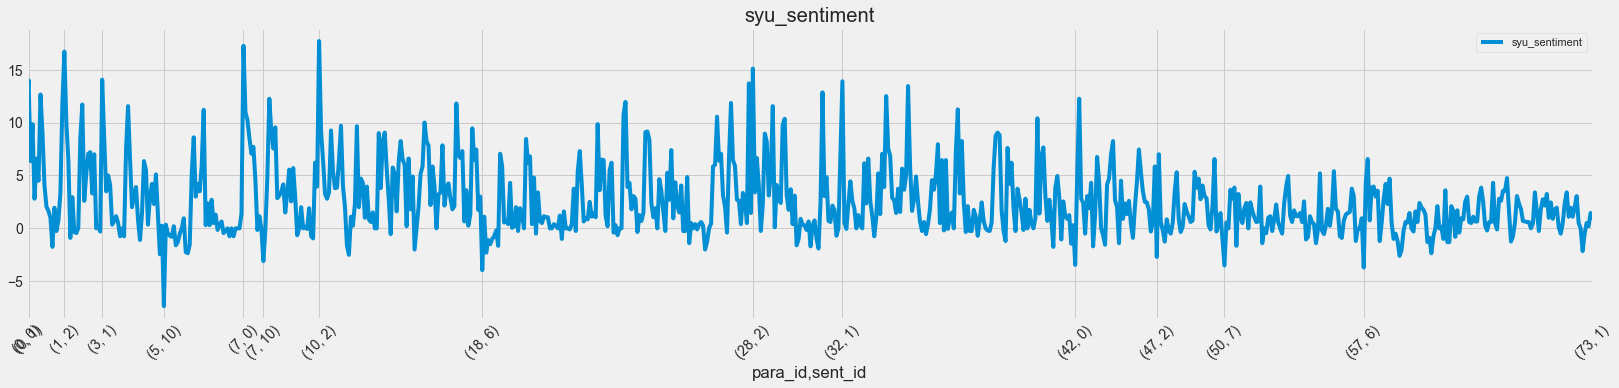

In [37]:
by_sent[emo].plot(**FIG, xticks=xticks, title=emo)

Its Emotional Valence is pretty greater than zero.

In [38]:
by_sent.iloc[xticks][emo].sort_index().to_frame()
#Clearly the entire sentiment is positive.
#Data is pretty different from the original corpus.
#Maybe in scientific literature, Coal is talked about in positive.

syu_sentiment
para_id sent_id               
0       0                11.70
        1                14.00
1       2                16.70
3       1                14.05
5       10               -7.35
7       0                17.25
        10               -3.10
10      2                17.70
18      6                -3.95
28      2                15.10
32      1                13.90
42      0                -3.45
47      2                -2.70
50      7                -3.50
57      6                -3.70
73      1                 0.85

### Inspect Positives

In [39]:
by_sent.sort_values(emo, ascending=False)[[emo,'sent_str']].head(20)

,,syu_sentiment,sent_str
para_id,sent_id,,
10,2,17.70,conversely context transcendent frames are app...
7,0,17.25,an approach referred to as the social construc...
1,2,16.70,among other eu countries estonia and the czech...
28,2,15.10,therefore the strategic creation of media cont...
3,1,14.05,through a systematic examination of all existe...
0,1,14.00,although the process could aid u s energy inde...
32,1,13.90,the choice to utilize easily accessible source...
28,0,13.70,it is important to note that few stories are e...
35,2,13.45,additionally results of this work also lack th...


### Inspect Negatives

In [40]:
by_sent.sort_values(emo, ascending=True)[[emo,'sent_str']].head(20)
#negative sentiments magnitudes are clearly less.

,,syu_sentiment,sent_str
para_id,sent_id,,
5,10,-7.35,more specifically exposure to hydraulic fractu...
18,6,-3.95,in short a policy regime perspective stresses ...
57,6,-3.70,thus measurement uncertainties unreliability a...
50,7,-3.50,for example there have been cases where oil co...
42,0,-3.45,the recent decline of energy prices especially...
7,10,-3.10,indeed the recent political developments outsi...
47,2,-2.70,additionally with the exception of sichuan the...
59,6,-2.60,highlight the importance of slo due to the uni...
11,9,-2.50,to meet the ec goals requires closing all lign...


## Apply Transforms

### Adapt Jockers' original FFT function 

Fast Fourier Transform. See https://rdrr.io/cran/syuzhet/man/get_transformed_values.html

In [41]:
def get_transformed_values(raw_values, low_pass_size = 2, x_reverse_len = 100,  padding_factor = 2, scale_values = False, scale_range = False):

    if low_pass_size > len(raw_values):
        sys.exit("low_pass_size must be less than or equal to the length of raw_values input vector")

    raw_values_len = len(raw_values)
    padding_len = raw_values_len * padding_factor

    # Add padding, then fft
    values_fft = fftpack.fft(raw_values, padding_len)
    low_pass_size = low_pass_size * (1 + padding_factor)
    keepers = values_fft[:low_pass_size]

    # Preserve frequency domain structure
    modified_spectrum = list(keepers) \
        + list(np.zeros((x_reverse_len * (1+padding_factor)) - (2*low_pass_size) + 1)) \
        + list(reversed(np.conj(keepers[1:(len(keepers))])))
    
    
    # Strip padding
    inverse_values = fftpack.ifft(modified_spectrum)
    inverse_values = inverse_values[:x_reverse_len]

#     transformed_values = np.real(tuple(inverse_values))
    transformed_values = np.real(inverse_values)
    return transformed_values

In [42]:
FFTCFG = dict(
    low_pass_size = 3,
    x_reverse_len = 100,
    padding_factor = 2
)
X = get_transformed_values(by_sent[emo].values, **FFTCFG)

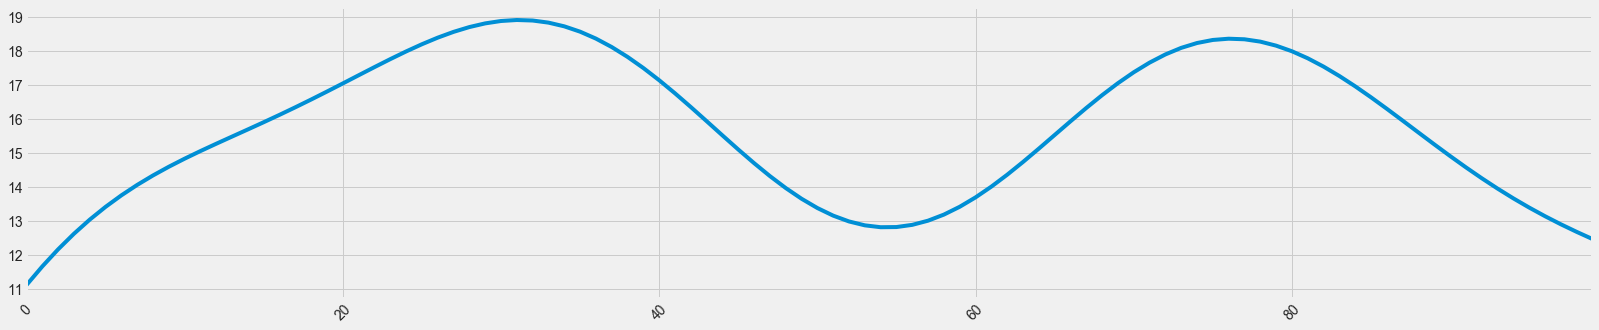

In [43]:
FIG['legend'] = False
pd.Series(X).plot(**FIG)

### Adapt Jockers' revised DCT function

Discrete Cosine Transform. A DCT is a Fourier-related transform similar to the discrete Fourier transform (DFT), but using only real numbers. This transformation was use in the paper to analyze the transformed plots as they don't show rolling.

In [44]:
def get_dct_transform(raw_values, low_pass_size = 5, x_reverse_len = 100):
    if low_pass_size > len(raw_values):
        raise ValueError("low_pass_size must be less than or equal to the length of raw_values input vector")
    values_dct = fftpack.dct(raw_values, type = 2)
    keepers = values_dct[:low_pass_size]
    padded_keepers = list(keepers) + list(np.zeros(x_reverse_len - low_pass_size))
    dct_out = fftpack.idct(padded_keepers)
    return(dct_out)

In [45]:
FFTCFG1 = dict(
    low_pass_size = 5,
    x_reverse_len = 100
)
X1 = get_dct_transform(by_sent[emo].values, **FFTCFG1)

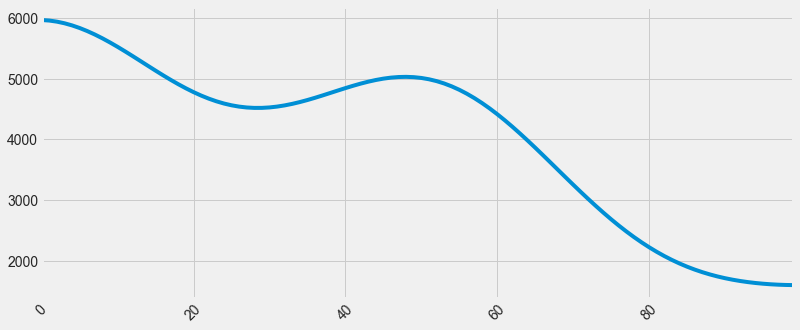

In [46]:
FIG['figsize'] = (12,5)
pd.Series(X1).plot(**FIG)

<img src="pers_rplot.jpg" width="900"/>

### Using Rolling
**Window types**: 
boxcar
triang
blackman
hamming
bartlett
parzen
bohman
blackmanharris
nuttall
barthann
kaiser (needs beta)
gaussian (needs std)
general_gaussian (needs power, width)
slepian (needs width).

In [47]:
# Config for tokens
CFG1 = dict(
    win_type='triang',
    window= int(tokens.shape[0]/ 9),
    center=True
)
CFG1['window']

10123

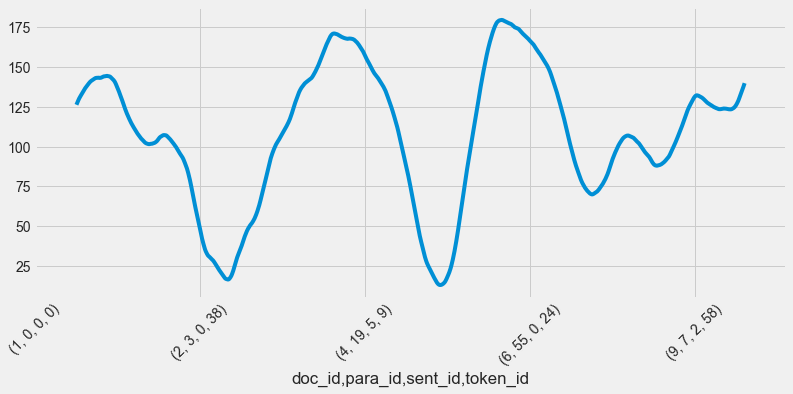

In [48]:
tokens[emo].fillna(0).rolling(**CFG1).sum().plot(**FIG)

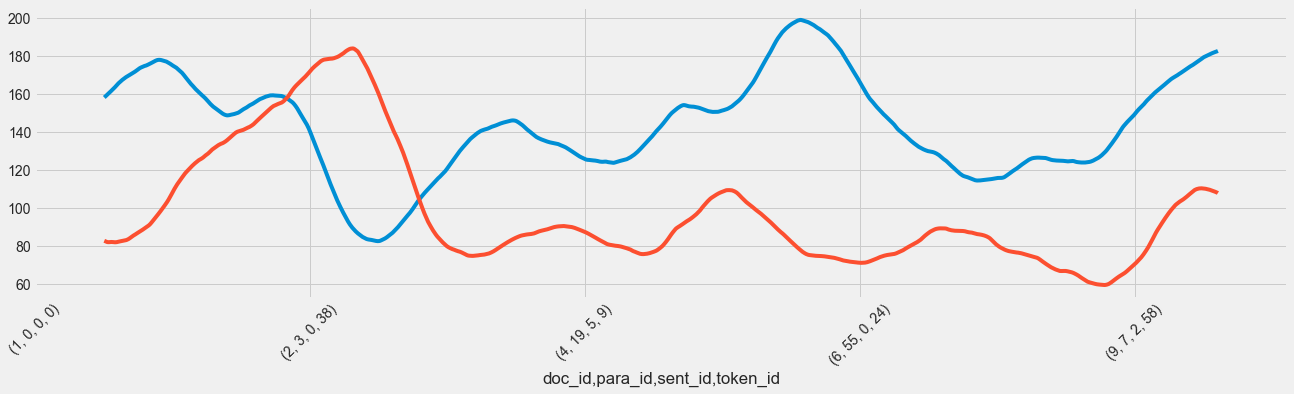

In [333]:
tokens[['nrc_positive','nrc_negative']].rolling(**CFG1).sum().plot(**FIG)
#legend is self-explainatory. blue being positive

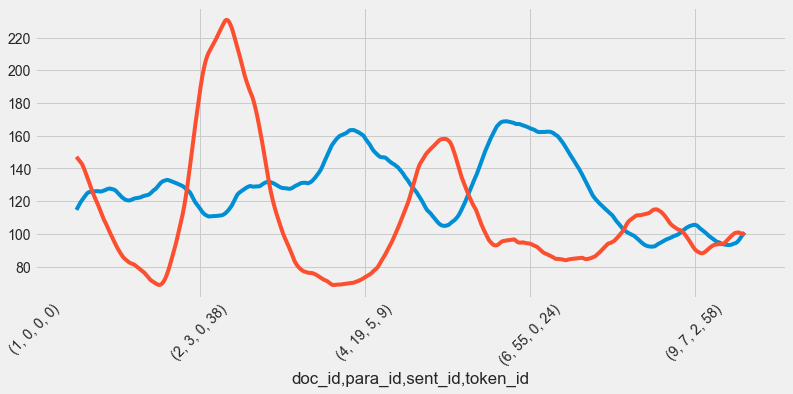

In [49]:
tokens[['bing_positive','bing_negative']].fillna(0).rolling(**CFG1).sum().plot(**FIG)

## Multinomial Emotions

In [51]:
EOM = tokens[emo_cols].reset_index(drop=True)

In [52]:
EOM.head()

,nrc_anger,nrc_anticipation,nrc_disgust,nrc_fear,nrc_joy,nrc_negative,nrc_positive,nrc_sadness,nrc_surprise,nrc_trust,bing_negative,bing_positive,bing_sentiment,syu_sentiment,gi_sentiment
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


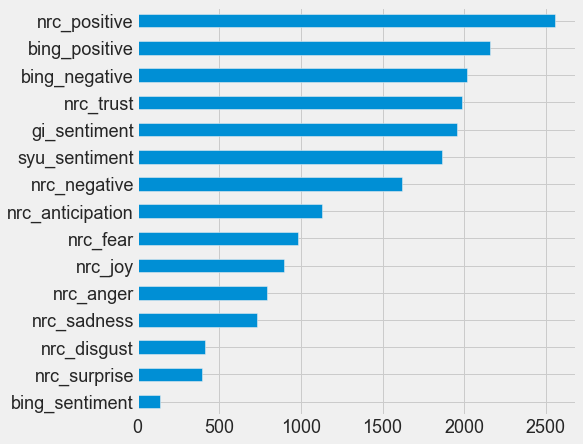

In [91]:
EOM.sum().sort_values().plot.barh(figsize=(7,7), fontsize=18)

As compared to corpus discussed in the paper this corpus is pretty positive for gas. Maybe the journal papers are less critical of these fossil fuels.

### Shape data for Sklearn's KDE function

In [53]:
emo_offsets = []
for col in emo_cols:
    x = EOM[EOM[col] > 0].index.tolist()
    y = [[i] for i in x]
    emo_offsets.append((col, y))
B = pd.DataFrame(emo_offsets, columns=['emo', 'x'])
B = B.set_index('emo')

In [54]:
B

,x
emo,
nrc_anger,"[[28], [233], [237], [253], [285], [645], [738..."
nrc_anticipation,"[[25], [30], [198], [206], [270], [287], [381]..."
nrc_disgust,"[[196], [232], [261], [263], [820], [1506], [1..."
nrc_fear,"[[232], [253], [270], [483], [550], [645], [82..."
nrc_joy,"[[25], [42], [132], [225], [320], [336], [632]..."
nrc_negative,"[[28], [196], [232], [233], [237], [253], [261..."
nrc_positive,"[[25], [30], [42], [74], [132], [198], [206], ..."
nrc_sadness,"[[237], [253], [738], [749], [804], [1417], [1..."
nrc_surprise,"[[25], [225], [320], [483], [550], [1067], [11..."


### Get KDE for each emotion

In [55]:
scale_max = EOM.shape[0]
kde_bandwidth = 2500
# kde_bandwidth = 250
x_axis = np.linspace(0, scale_max, kde_samples)[:, np.newaxis]
B['kde'] = B.apply(lambda row: KDE(kernel=kde_kernel, bandwidth=kde_bandwidth).fit(row.x), 1)
B['scores'] = B.apply(lambda row: row.kde.score_samples(x_axis), axis=1)
PLOTS = B.apply(lambda row: pd.Series(np.exp(row.scores) * (scale_max / kde_samples)), axis=1).T

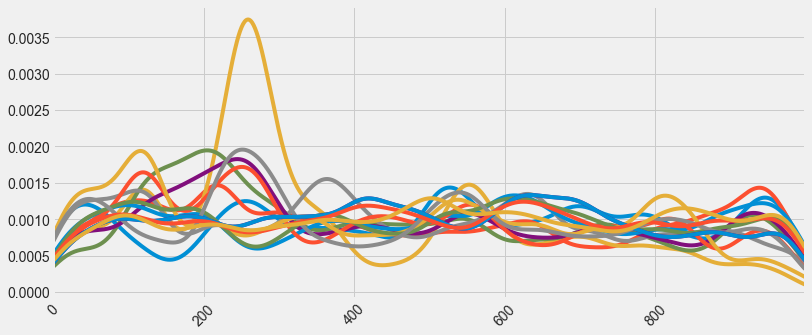

In [56]:
PLOTS.plot(**FIG)

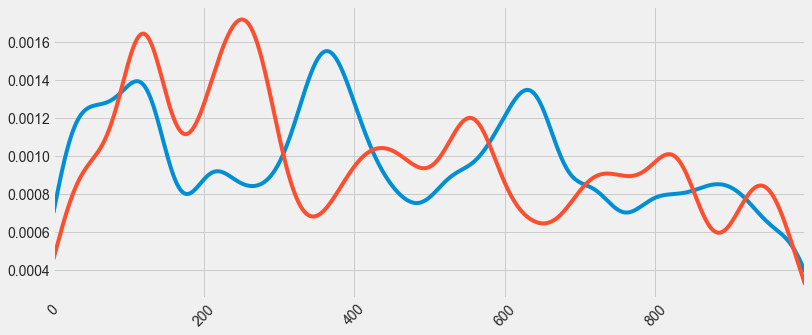

In [57]:
PLOTS[['nrc_joy','nrc_sadness']].plot(**FIG)

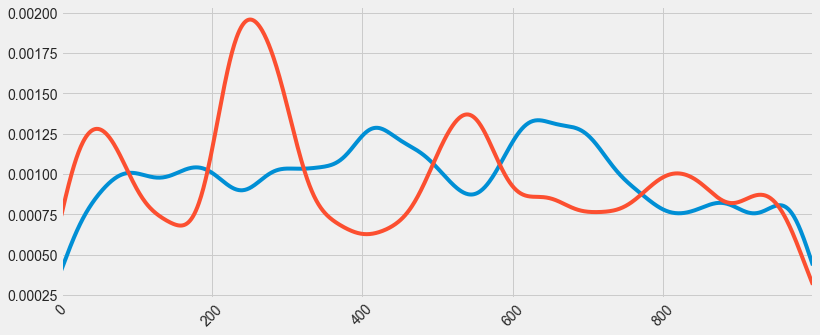

In [58]:
PLOTS[['bing_positive','bing_negative']].plot(**FIG)

### Compare KDE to Rolling graphs of Sentiment

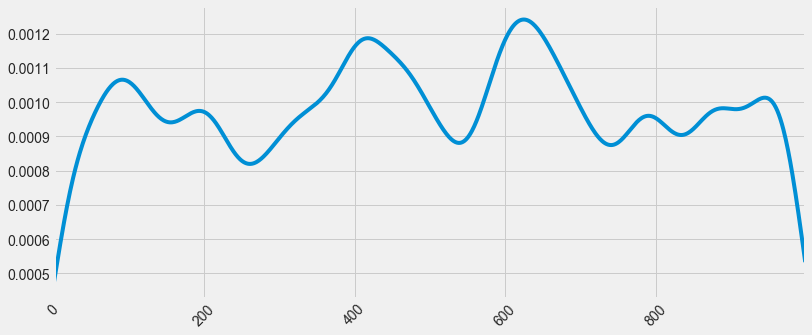

In [59]:
PLOTS[emo].plot(**FIG)

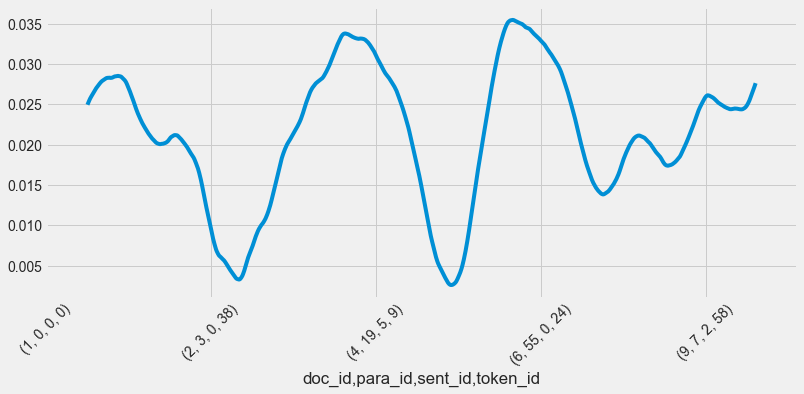

In [60]:
tokens[emo].fillna(0).rolling(**CFG1).mean().plot(**FIG)
#A bit more wavy

## Peak Negative

### Find max negative from PLOTS

In [61]:
PLOTS.head()

emo,nrc_anger,nrc_anticipation,nrc_disgust,nrc_fear,nrc_joy,nrc_negative,nrc_positive,nrc_sadness,nrc_surprise,nrc_trust,bing_negative,bing_positive,bing_sentiment,syu_sentiment,gi_sentiment
0,0.000757,0.000456,0.000403,0.000350,0.000701,0.000462,0.000524,0.000457,0.000790,0.000482,0.000740,0.000403,0.000403,0.000467,0.000435
1,0.000776,0.000469,0.000416,0.000359,0.000721,0.000475,0.000539,0.000472,0.000812,0.000498,0.000760,0.000415,0.000415,0.000481,0.000447
2,0.000795,0.000482,0.000428,0.000369,0.000741,0.000488,0.000554,0.000486,0.000835,0.000513,0.000781,0.000427,0.000427,0.000495,0.000459
3,0.000814,0.000495,0.000441,0.000379,0.000761,0.000501,0.000570,0.000501,0.000858,0.000528,0.000801,0.000440,0.000440,0.000508,0.000471
4,0.000833,0.000508,0.000453,0.000388,0.000781,0.000514,0.000585,0.000516,0.000880,0.000544,0.000820,0.000452,0.000452,0.000522,0.000483


In [62]:
PEAK_NEGATIVE = int((PLOTS['nrc_negative'].idxmax() / 1000) * tokens.shape[0])

In [63]:
PEAK_NEGATIVE_DOC_NUM = tokens.iloc[PEAK_NEGATIVE].name[0]

In [64]:
PEAK_NEGATIVE_DOC_NUM

'2'

### DisplayParagraphs

In [65]:
PEAK_NEGATIVE_PARA = tokens.loc[PEAK_NEGATIVE_DOC_NUM].groupby(['para_id']).token_str.apply(lambda x: ' '.join(x)).tolist()

In [66]:
display(HTML('<br/><br/>'.join(PEAK_NEGATIVE_PARA)))
#A lot about social and environemental risks of coal which makes sense.

## VADER

In [67]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [68]:
vader_cols = by_sent.sent_str.apply(analyser.polarity_scores).apply(lambda x: pd.Series(x))

In [69]:
by_sent = pd.concat([by_sent, vader_cols], axis=1)
by_sent.head()

nrc_anger  nrc_anticipation  nrc_disgust  nrc_fear  nrc_joy  \
para_id sent_id                                                                
0       0              1.0               4.0          0.0       3.0      3.0   
        1              1.0               4.0          1.0       0.0      3.0   
        2              0.0               3.0          1.0       4.0      4.0   
        3              1.0               3.0          1.0       5.0      1.0   
        4              2.0               5.0          2.0       5.0      3.0   

                 nrc_negative  nrc_positive  nrc_sadness  nrc_surprise  \
para_id sent_id                                                          
0       0                 3.0           8.0          0.0           1.0   
        1                 2.0          11.0          0.0           3.0   
        2                 3.0           6.0          1.0           1.0   
        3                 6.0           5.0          0.0           0.0   
        4                 3.0           7.0          2.0           2.0   

                 nrc_trust  bing_negative  bing_positive  bing_sentiment  \
para_id sent_id                                                            
0       0              5.0            4.0           11.0             7.0   
        1              9.0            5.0            6.0             1.0   
        2              4.0            8.0            4.0            -4.0   
        3              5.0            5.0            9.0             4.0   
        4              6.0           10.0            7.0            -3.0   

                 syu_sentiment  gi_sentiment  \
para_id sent_id                                
0       0                11.70          14.0   
        1                14.00          12.0   
        2                 6.35          14.0   
        3                 9.85           7.0   
        4                 2.80           9.0   

                                                          sent_str    neg  \
para_id sent_id                                                             
0       0        ï hydraulic fracturing often called fracking i...  0.035   
        1        although the process could aid u s energy inde...  0.034   
        2        guided by agenda setting and framing this stud...  0.103   
        3        results show cable news lacks substance and re...  0.036   
        4        while all networks failed to provide factual i...  0.092   

                   neu    pos  compound  
para_id sent_id                          
0       0        0.841  0.124    0.9455  
        1        0.826  0.140    0.9860  
        2        0.794  0.104    0.0790  
        3        0.856  0.109    0.9590  
        4        0.824  0.084   -0.3015

In [70]:
#Negative's magnitude is not the greatest for coal contradictory to the paper.
by_sent=by_sent.groupby(by_sent.columns, axis=1).agg(np.max)
by_sent.sort_values('neg', ascending=False).head(10)

,,bing_negative,bing_positive,bing_sentiment,compound,gi_sentiment,neg,neu,nrc_anger,nrc_anticipation,nrc_disgust,nrc_fear,nrc_joy,nrc_negative,nrc_positive,nrc_sadness,nrc_surprise,nrc_trust,pos,sent_str,syu_sentiment
para_id,sent_id,,,,,,,,,,,,,,,,,,,,
30,18,0.0,0.0,0.0,-0.8074,-1.0,0.342,0.658,1.0,2.0,0.0,2.0,0.0,2.0,2.0,2.0,1.0,1.0,0.000,moreover after the nuclear accident in japan p...,-1.90
66,5,2.0,0.0,-2.0,-0.5499,-2.0,0.318,0.535,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.147,but under what circumstances will the leakage ...,-0.75
5,10,8.0,1.0,-7.0,-0.9477,-6.0,0.310,0.690,4.0,0.0,3.0,4.0,0.0,7.0,0.0,7.0,0.0,0.0,0.000,more specifically exposure to hydraulic fractu...,-7.35
3,12,1.0,0.0,-1.0,-0.6115,-1.0,0.307,0.693,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.000,specifically liberals harbor more negative att...,-0.75
30,8,0.0,0.0,0.0,-0.7845,-2.0,0.301,0.699,1.0,0.0,0.0,2.0,0.0,2.0,0.0,1.0,0.0,0.0,0.000,attempts to mine uranium after world war ii in...,-1.00
3,10,1.0,0.0,-1.0,-0.4522,1.0,0.270,0.730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,recent studies have shed more light on conflic...,-0.75
52,6,1.0,0.0,-1.0,-0.0900,0.0,0.260,0.505,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.235,it would be sinful not to use this opportunity,-0.25
50,7,4.0,1.0,-3.0,-0.8316,-1.0,0.260,0.700,0.0,0.0,3.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.040,for example there have been cases where oil co...,-3.50
22,10,1.0,0.0,-1.0,-0.3400,-1.0,0.255,0.745,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,this fire burns as high as this house,-0.65


In [71]:
CFG1['window'] = 50

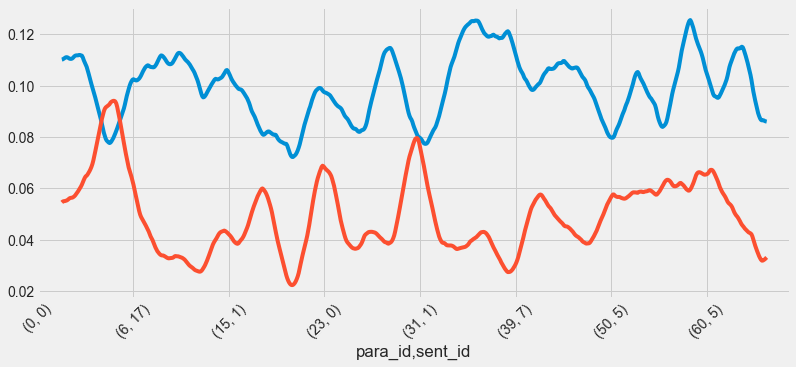

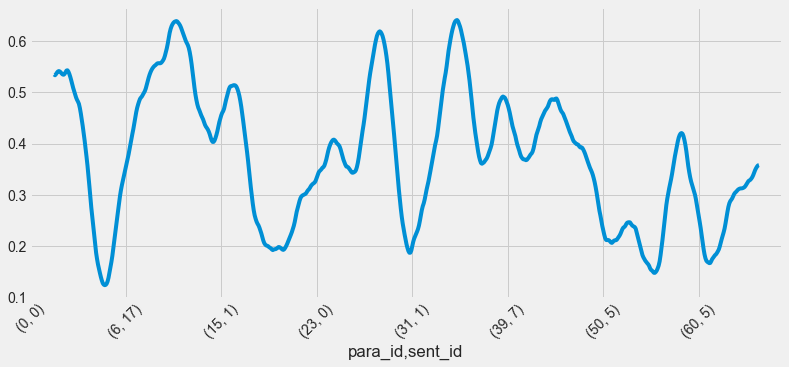

In [72]:
by_sent[['pos','neg']].rolling(**CFG1).mean().plot(**FIG)
by_sent[['compound']].rolling(**CFG1).mean().plot(**FIG)
#compoud shows the valence is positive for coal in the dataset.

## Compare KDE to Rolling Both Graphs of Syuzhet and VADER

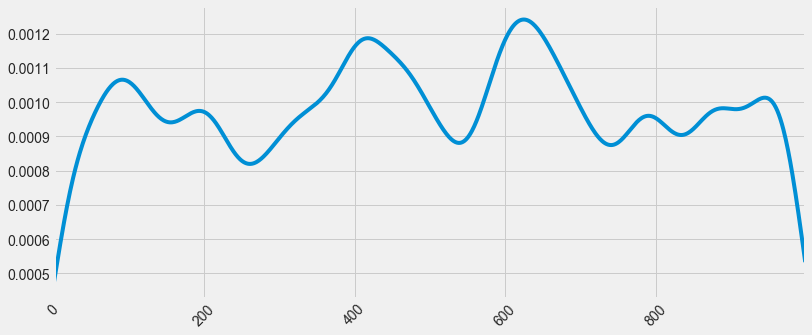

In [73]:
PLOTS[emo].plot(**FIG)

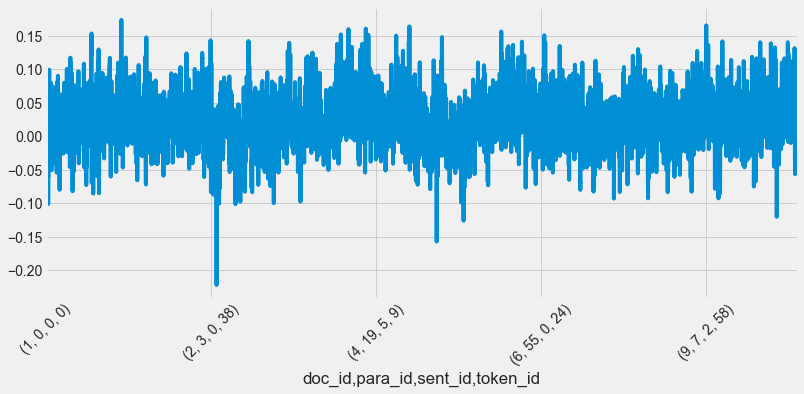

In [74]:
tokens[emo].fillna(0).rolling(**CFG1).mean().plot(**FIG)

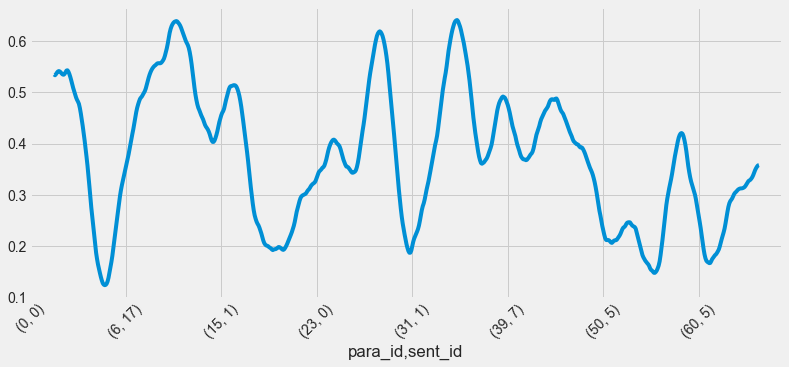

In [75]:
by_sent[['compound']].rolling(**CFG1).mean().plot(**FIG)

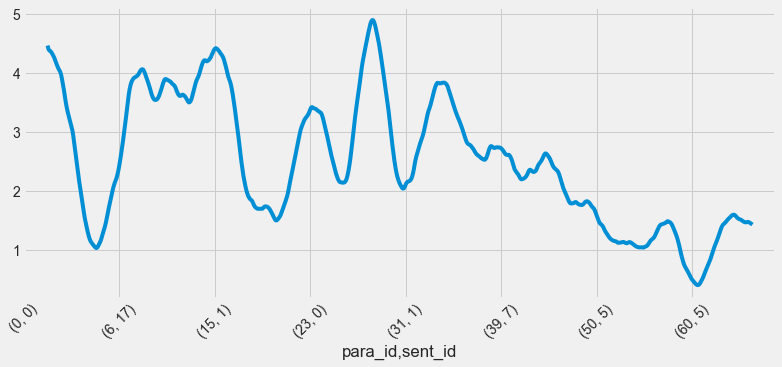

In [76]:
by_sent[emo].fillna(0).rolling(**CFG1).mean().plot(**FIG)

## Experimental Plotting Function

In [77]:
def  plot_sentiment(emo_col, type='sent'):
    if type == 'sent':
        by_sent[emo_col].fillna(0).rolling(**CFG1).mean().plot(**FIG)
    elif type == 'tokens':
        tokens[emo_col].fillna(0).rolling(**CFG2).mean().plot(**FIG)
    elif type == 'kde':
        PLOTS[emo_col].plot(**FIG)
    else:
        pass

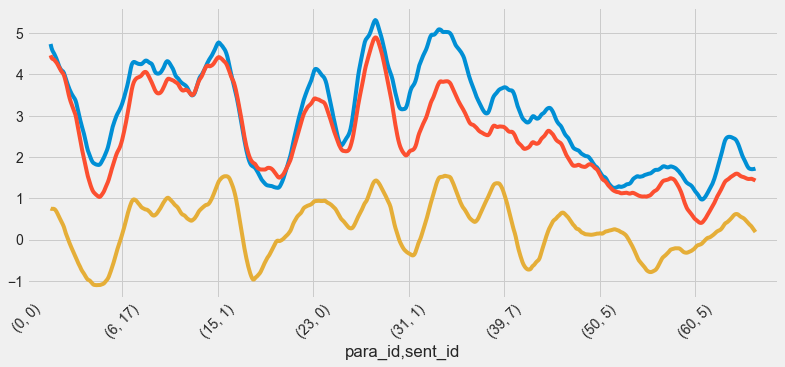

In [78]:
plot_sentiment('gi_sentiment')
plot_sentiment('syu_sentiment')
plot_sentiment('bing_sentiment')
#blue-gi
#red-syu
#yellow-bing

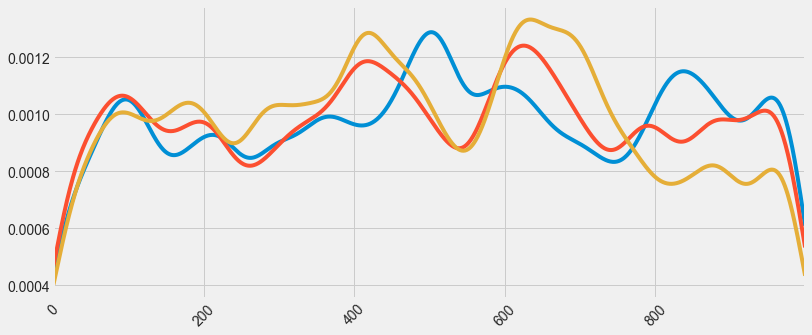

In [79]:
plot_sentiment('gi_sentiment', type='kde')
plot_sentiment('syu_sentiment', type='kde')
plot_sentiment('bing_sentiment', type='kde')